In [1]:
import csv
import math

import pandas as pd
import requests
import numpy as np

### Dataset Location
The Dataset cannot be pushed to Github. Github has decreased the allowed file size so the dataset will have to be downloaded manually.

The url is: https://data.cms.gov/provider-data/sites/default/files/resources/69a75aa9d3dc1aed6b881725cf0ddc12_1671768321/DAC_NationalDownloadableFile.csv

The Data Dictionary for this section of datasets: https://data.cms.gov/provider-data/sites/default/files/data_dictionaries/physician/DOC_Data_Dictionary.pdf

The webpage for this section of datasets: https://data.cms.gov/provider-data/topics/doctors-clinicians

In [2]:
df = pd.read_csv('DAC_NationalDownloadableFile.csv', encoding='windows-1252', dtype='string')

### Filtering and Cleaning the Dataset

In [3]:
# NOTE: Optimize This
speciality_locations = df[['adr_ln_1', 'cty', 'st', 'zip','pri_spec']]
speciality_locations = speciality_locations.replace(r'^s*$', np.nan, regex=True)
speciality_locations.dropna(inplace=True)
speciality_locations['latitude'] = speciality_locations['longitude'] = np.nan
print(speciality_locations.head())
print('Number of entries:',speciality_locations.shape[0])

             adr_ln_1             cty  st        zip                pri_spec  \
0     1582 N BROAD ST        TAZEWELL  TN  378794352      NURSE PRACTITIONER   
1   5632 ANNAPOLIS RD     BLADENSBURG  MD  207102213      NURSE PRACTITIONER   
2    611 E CARLSON ST        CHEYENNE  WY  820094335       INTERNAL MEDICINE   
3         30 RIVER ST      JIM THORPE  PA  182292313            CHIROPRACTIC   
4  20501 VENTURA BLVD  WOODLAND HILLS  CA  913640847  CLINICAL SOCIAL WORKER   

   latitude  longitude  
0       NaN        NaN  
1       NaN        NaN  
2       NaN        NaN  
3       NaN        NaN  
4       NaN        NaN  
Number of entries: 2472219


In [4]:
#Printing Unique Primary Specialites to Filter From
print(speciality_locations['pri_spec'].unique())

<StringArray>
[                                     'NURSE PRACTITIONER',
                                       'INTERNAL MEDICINE',
                                            'CHIROPRACTIC',
                                  'CLINICAL SOCIAL WORKER',
                                               'OPTOMETRY',
                                          'ANESTHESIOLOGY',
                                         'FAMILY PRACTICE',
                                               'NEUROLOGY',
                                   'CLINICAL PSYCHOLOGIST',
                                             'DERMATOLOGY',
                                        'PHYSICAL THERAPY',
                                           'OPHTHALMOLOGY',
                                      'ORTHOPEDIC SURGERY',
                                             'HOSPITALIST',
                                              'PSYCHIATRY',
                                            'ORAL SURGERY',
                          

In [5]:
#Selecting the specialites to use from the pri_spec column by removing the extranious specialites 
specialites_to_remove = [
    'CLINICAL SOCIAL WORKER',
    'UNDEFINED NON-PHYSICIAN TYPE (SPECIFY)',
    'UNDEFINED PHYSICIAN TYPE (SPECIFY)',
    'MEDICAL GENETICS AND GENOMICS',
    'MEDICAL TOXICOLOGY',
    'MASS IMMUNIZATION ROSTER BILLER'
]
indexes_to_remove = speciality_locations[ speciality_locations['pri_spec'].isin(specialites_to_remove) ].index
speciality_locations.drop(indexes_to_remove, inplace=True)

In [6]:
batches = math.ceil(speciality_locations.shape[0] / 10000)
print(batches)

242


### Steps to Get Geolocations of Addresses in Batch
1. Create a loop that generates a CSV for each 247 entries 
2. Send the generated CSV to the Census GOV Geolocation API for processing
3. Recieve the response and append it to a local CSV 
4. Rinse and repeat until all addresses are converted to geolocations (lat. and long.) to use with a map

### Testing using Test Address

In [7]:
URL = 'https://geocoding.geo.census.gov/geocoder/locations/addressbatch'
with open('test_addresses.csv', 'rb') as input_file:
    geo = requests.post(files={'addressFile': input_file}, url=URL, data={'benchmark':'Public_AR_Current'})

In [8]:
response_content = str(geo.content)
print(response_content)

b'"000001","20 W 34th St., New York,  NY,  10001","Match","Non_Exact","20 W 34TH ST, NEW YORK, NY, 10118","-73.98533698799997,40.748757279000074","59653429","L"\n'


### Extracting out the latitude and Longitude from the Test Address

In [9]:
lat, long = response_content.split('","')[5].split(',')  # Pretty hardcoded, but it works
print("lat: ", lat, "long: ", long)

lat:  -73.98533698799997 long:  40.748757279000074


### Example Test Address Plotting Using Geopandas

In [10]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon

<AxesSubplot:>

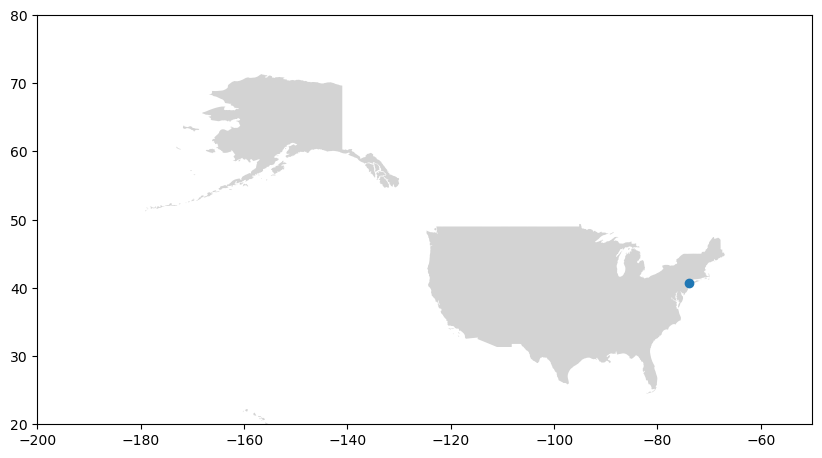

In [11]:
us_nation_map = gpd.read_file('./cb_2021_us_nation_20m/cb_2021_us_nation_20m.shp')

fig, ax = plt.subplots(figsize=(10, 10))
us_nation_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')

ax.set_xlim(-200, -50)
ax.set_ylim(20, 80)

crs = 'EPSG:4326'
geometry = [Point(float(lat), float(long))]
geo_df = gpd.GeoDataFrame(pd.DataFrame(), crs=crs, geometry=geometry)
geo_df.plot(ax=ax)